## Fluorescence emission of one Chlamydomonas reinhardtii cell depending on excitation wavelength

#### You can change 
- emission wavelength
- emission intensity (log(I) where I is expressed in eins/m²/s)
- integration time (log(T) where T is expressed is s)

In [1]:
#nbi:hide_in
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np

import pandas as pd 
import numpy as np
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import alienlab.plot
import radiometry


In [2]:
#nbi:hide_in
Na = 6.022e23
volume_chloroplast = 130e-18 #m3 https://bionumbers.hms.harvard.edu/bionumber.aspx?&id=110528&ver=2
mass_chloroplast = volume_chloroplast * 1e6 #g assuming same density as water
surface_chloroplast = 25e-12 #m2 https://bionumbers.hms.harvard.edu/bionumber.aspx?id=107012
volume_cell = 270e-18 #m3 https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=2&id=110530
mass_cell = volume_cell * 1e6 #g assuming algae density is water density
surface_cell = 48e-12 #m2 https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=2&id=107595

In [3]:
#nbi:hide_in
antenna_size = 230 #chlorophyll molecules https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100847&ver=2&trm=chlorophyll&org=
chlorophyll_molecules_per_cell = 3e-15 * Na # https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100852&ver=3&trm=chlorophyll&org=
chlorophyll_concentration_in_chloroplast = 30e-3 *1e3 #mol/m3 https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100913&ver=1&trm=chloroplast&org=
sigma_chlorophyll = 0.29e-20 #m2 596nm ABSOLUTE ABSORPTION CROSS-SECTIONS FOR PHOTOSYSTEM II AND THE MINIMUM QUANTUM REQUIREMENT FOR PHOTOSYNTHESIS IN CHLORELLA VULGARIS
sigma_RC = 50e-20 #m2 596nm review Mauzerall 1996 and ABSOLUTE ABSORPTION CROSS-SECTIONS FOR PHOTOSYSTEM II AND THE MINIMUM QUANTUM REQUIREMENT FOR PHOTOSYNTHESIS IN CHLORELLA VULGARIS
sigma_cell_per_g_of_dry_weight = 0.3 #m2/g 596nm Impact of light color on photobioreactor productivity -and- Simple method for measuring the spectral absorption cross-section of microalgae

q_fluo_chlamy = 0.01 #quantum fluorescence yield
collection_angle = 60 #collection angle of the detector
pixel_surface = 30e-12 #m2

In [4]:
#nbi:hide_in
#Intermediate growth light
intermediate_chlorophyll_per_cell = 3.3e-16 #chl (a+b)/cell
intermediate_sigma = 60e-20 #m2
intermediate_antenna_size = 210 #chl(a+b)/cell
intermediate_RC_per_cell = intermediate_chlorophyll_per_cell / intermediate_antenna_size #assuming RCII/RCI = 1 and antenna size are equal

In [5]:
#nbi:hide_in
light_intensity = 100 * 1e-6 #E/m2/s
wavelength = 450e-9 #m
integration_period = 1e-3 #s
LED_bandwidth = 5
LED_viewangle = 60


In [6]:
#nbi:hide_in
#Medium light
medium_light = 60e-20/230 * 3e-16 * Na #from table

sigma_chlamy = 1e-12 #m²

In [7]:
#nbi:hide_in
#Collect the data of the graph and interpolate for given wavelength

abs_chlamy = pd.read_csv("save_figures/graph_sigma.csv", names = ['wavelength', 'sigma'], sep = ';', decimal = ',') 
abs_chlamy.sigma = abs_chlamy.sigma * mass_cell * 0.1 #convert m²/g to m² assuming dry mass is 10% of cell mass

# Shift the graph to match intermediate growth light 
# Intepolate sigma = f(wavelength)
X = abs_chlamy.wavelength.values
Y = abs_chlamy.sigma.values
sigma_chlamy = InterpolatedUnivariateSpline(X, Y)
sigma_wavelength = sigma_chlamy(596) #from Intermediate values for Chlorella ABSOLUTE ABSORPTION CROSS-SECTIONS FOR PHOTOSYSTEM II AND THE MINIMUM QUANTUM REQUIREMENT FOR PHOTOSYNTHESIS IN CHLORELLA VULGARIS, Ley and Mauzerall
abs_chlamy.sigma = abs_chlamy.sigma * medium_light / sigma_wavelength # Shift graph values to obtain medium light growth references

fluo_chlamy = pd.read_csv("save_figures/fluo_chlamy.csv", names = ['wavelength', 'fluo'], sep = ';', decimal = ',') 
fluo_chlamy.fluo = fluo_chlamy.fluo/fluo_chlamy.fluo.max()
   



In [8]:
#nbi:hide_in
#Saturation : tau = 100 photons-/s per RC #Aquatic Photosynthesis Falkowski
#I_sat * sigma_lambda = tau * reaction_center_number
p = alienlab.plot.PlotFigure()
tau = 100 #photons-/s
I_sat = tau / abs_chlamy.sigma * intermediate_RC_per_cell
p.title = 'Saturation intensity for LED centered at X-axis wavelength \n for algae grown at 80 µeins/m²/s incandescent light '
p.ylabel = 'Saturation intensity µeins/m²/s'
p.xlabel = 'Central wavelength of excitation light (nm)'


In [9]:
#nbi:hide_in
class fluorophore:
    def __init__(self):
        self.abs_spectrum = [] # in m²
        self.fluo_spectrum = [] # normalized
        self.saturation = False # is there a light saturation process?
        self.q_fluo = 1 #fluorescence yield
        self.species = "Fluorophore name"
        self.min_wavelength = 400 #nm
        self.max_wavelength = 750 #nm
        self.turnover_rate = 100 #excitation/s
        self.x_total = np.arange(self.min_wavelength, self.max_wavelength, 1) #reference wavelength scale
        self.collection_angle = 60
        
    def complete_spectrum(self, X, Y):
        """ extrapolates to zero the values of the array y over the 
        wavelength range of x_total, knowing only the values over X"""
        Y = np.array([y for x, y in sorted(zip(X, Y))]) #preliminary sorting of the arrays along wavelength 
                                                            #(in case the graph in not properly ordered)
        X = np.sort(X)
        d = int(X.min())
        f = int(X.max())
        x_spectrum = np.arange(d, f, 1)
        func = InterpolatedUnivariateSpline(X, Y) # interpolate given values with step 1 nm
        y_func = func(x_spectrum)
        y = (self.x_total * 0).astype(float) # Set y to zero everywhere
        y[d-self.min_wavelength: f-self.min_wavelength] = y_func # Assign spectrum values on konwn portion of spectrum
        return func, y
        
    def photon_emitted(self, wavelength, light_intensity, integration_period):
        # Intepolate sigma = f(wavelength)
        X = self.abs_spectrum.wavelength.values
        Y = self.abs_spectrum.sigma.values
        self.sigma_func, y_abs = self.complete_spectrum(X, Y)
        
        # Intepolate emission = f(wavelength)
        X = self.fluo_spectrum.wavelength.values
        Y = self.fluo_spectrum.fluo.values
        self.fluofunc, y_emission = self.complete_spectrum(X, Y)    

        #Excitation source LED band_width = 20nm, viewangle = 60°, overall_power = light_intensity
        if self.saturation:
            waverange = np.arange(wavelength - LED_bandwidth, wavelength + LED_bandwidth, 1)
            I_sat = self.turnover_rate / np.mean(self.sigma_func(waverange)) * intermediate_RC_per_cell
            light_intensity = min(np.log(I_sat)/np.log(10), light_intensity)
        excitation = radiometry.LED(wavelength, LED_bandwidth, LED_viewangle, 10**light_intensity)     
        excitation.X = self.x_total
        excitation_spectrum = excitation.spectrum(plot = False) #eins/m²/s/nm 

        #quantity of photons absorbed by the algae per sec
        I_abs = y_abs * excitation_spectrum * Na #photons/s/nm
        #p.plotting(excitation.X, excitation_spectrum*I_abs)

        #integrate over spectrum
        energy_absorbed = np.trapz(I_abs, self.x_total) #photons/s

        self.photons_emitted = self.q_fluo * energy_absorbed * 10**integration_period #fluorescecnce and collection angle
        #fig = p.plotting(excitation.X, I_abs)
        print('Number of photons emitted per algae during acquisition: %0.2f'%self.photons_emitted)
        n_pixels = surface_cell/pixel_surface*10
        print(n_pixels)
        print('Number of photons collected per brigt pixel during acquisition: %0.2f'%(self.photons_emitted/n_pixels*self.collection_angle / 360 ))

        full_fluo = np.trapz(y_emission, self.x_total)
        scaling = self.photons_emitted / full_fluo 
        self.fluo_output = y_emission * scaling
        
        # plotting
        p.title = "Photons emitted by %s"%self.species
        p.xlabel = "Emission wavelength (nm)"
        p.ylabel = 'Absorbption cross-section of \n %s (m² per unit)'%self.species
        p.y2label = 'Fluorescence emission (photons/unit/nm)'
        p.label_list = ['absorbption spectrum (m²)', 'light source spectrum (total energy %f E/m²/s)'%(10**light_intensity)]
        p.xval = self.x_total
        #print(abs_spectrum.sigma.values.max()/excitation_spectrum.max(), abs_spectrum.sigma.values.max(), excitation_spectrum.max())
        p.yval = [y_abs, excitation_spectrum * y_abs.max()/excitation_spectrum.max()]
        p.label2_list = ['fluorescence (photons/unit/nm)']
        p.x2val = self.x_total
        p.y2val = y_emission

        #print(p.xval.shape, p.x2val.shape)
        #print(p.yval[0].shape, p.yval[1].shape, p.y2val.shape)

        p.coplotting()


chlamy = fluorophore()
chlamy.abs_spectrum = abs_chlamy
chlamy.fluo_spectrum = fluo_chlamy
chlamy.q_fluo = q_fluo_chlamy     
chlamy.turnover_rate = tau
chlamy.saturation = False
chlamy.species = "Chlamydomonas reinhardtii"

dis = interact(chlamy.photon_emitted, wavelength = (400, 700), light_intensity = (-6, -2), integration_period = (-6, -1))

interactive(children=(IntSlider(value=550, description='wavelength', max=700, min=400), IntSlider(value=-4, de…

Number of photons emitted per algae during acquisition: 24.20
16.0
Number of photons collected per brigt pixel during acquisition: 0.25
Number of photons emitted per algae during acquisition: 169.25
16.0
Number of photons collected per brigt pixel during acquisition: 1.76
Number of photons emitted per algae during acquisition: 1354.03
16.0
Number of photons collected per brigt pixel during acquisition: 14.10
Number of photons emitted per algae during acquisition: 27080.59
16.0
Number of photons collected per brigt pixel during acquisition: 282.09
Number of photons emitted per algae during acquisition: 863193.79
16.0
Number of photons collected per brigt pixel during acquisition: 8991.60
Number of photons emitted per algae during acquisition: 1358974.54
16.0
Number of photons collected per brigt pixel during acquisition: 14155.98


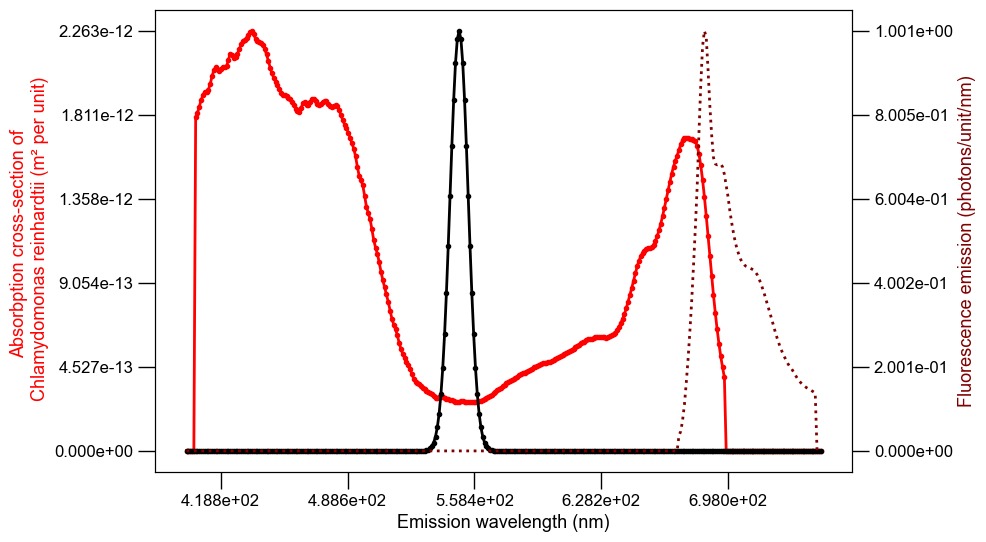

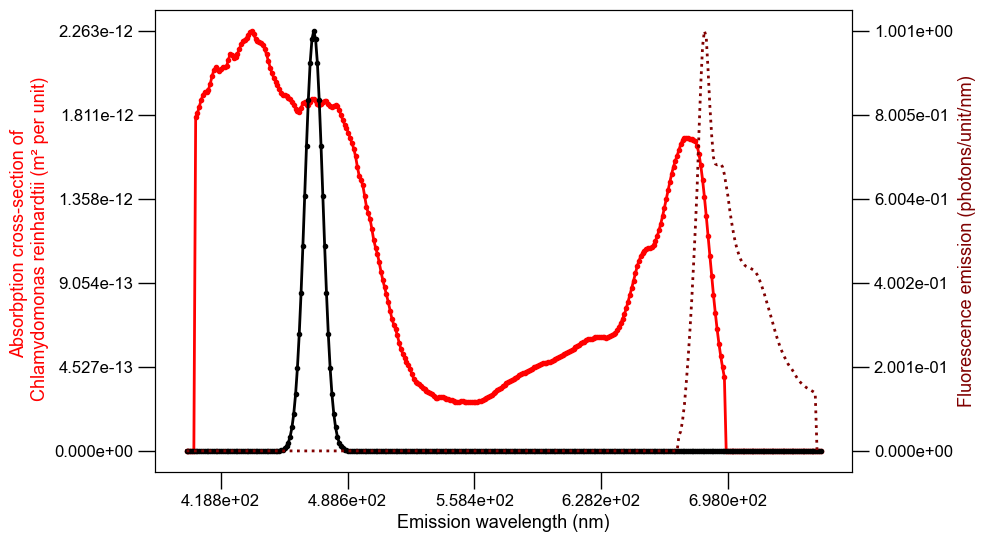

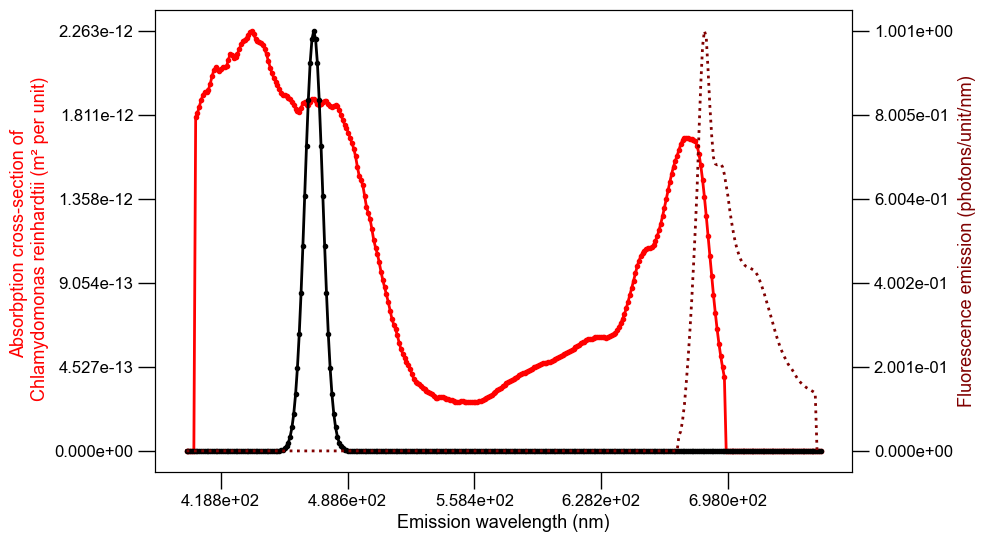

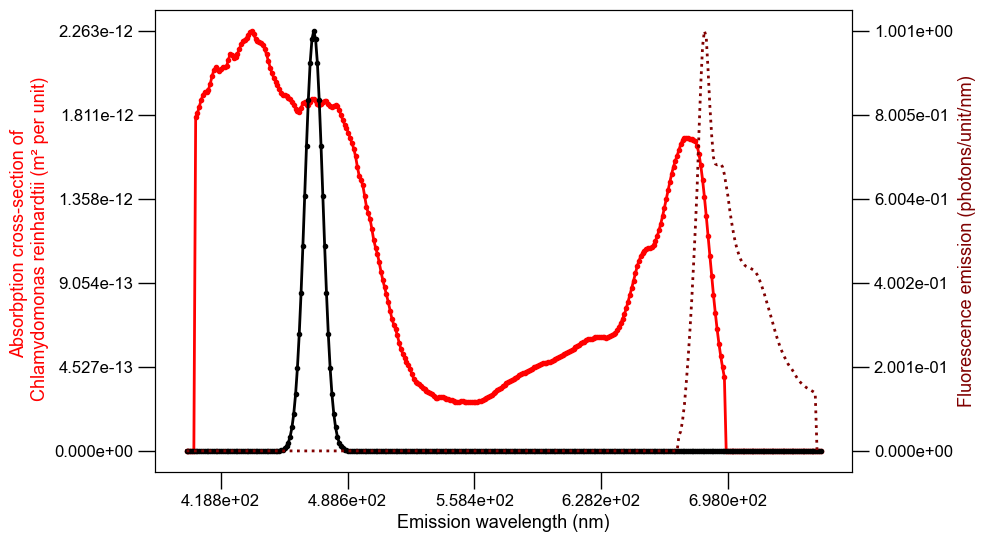

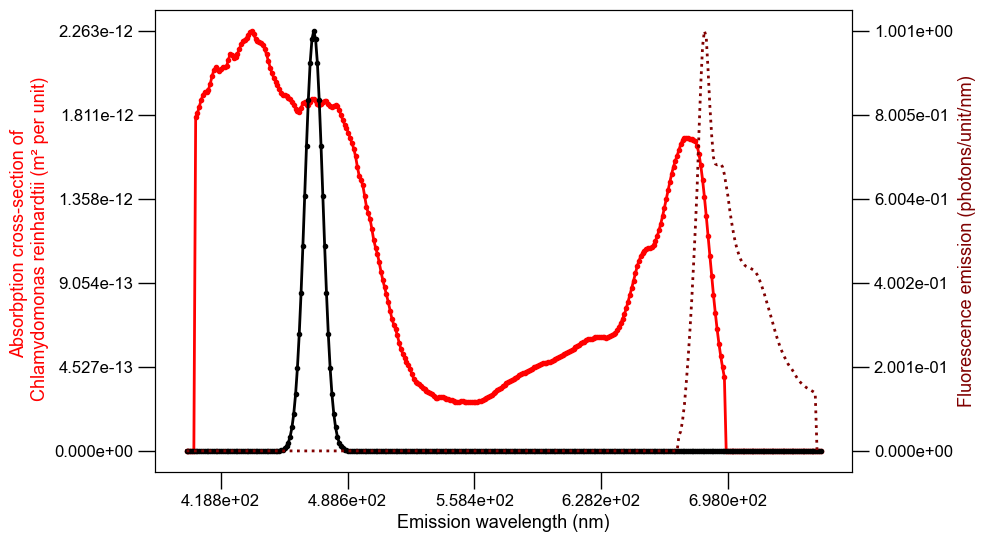

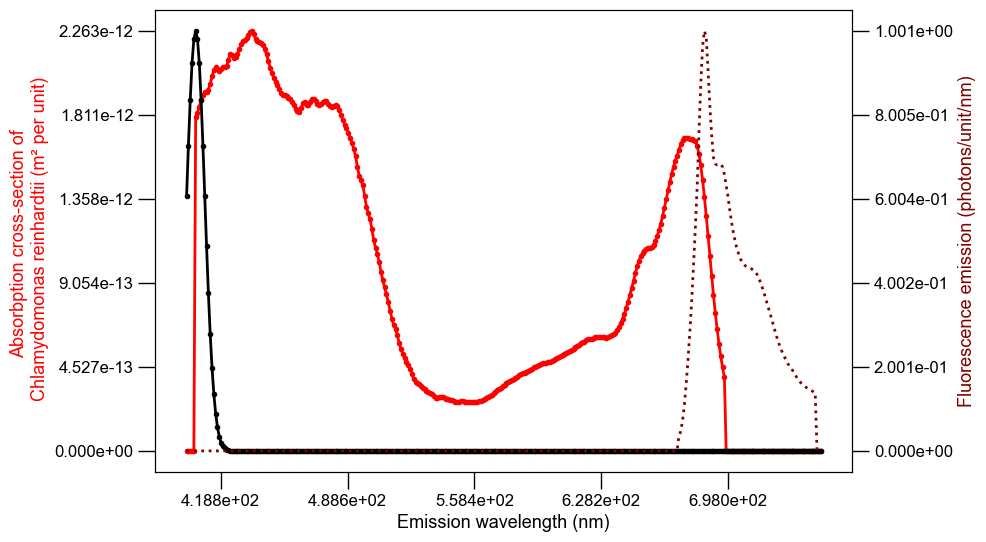

In [10]:

chlamy.photon_emitted(550, np.log10(5e-6), np.log10(3e-3))
chlamy.photon_emitted(470, np.log10(5e-6), np.log10(3e-3))
chlamy.photon_emitted(470, np.log10(40e-6), np.log10(3e-3))
chlamy.photon_emitted(470, np.log10(40e-6), np.log10(60e-3))

chlamy.photon_emitted(470, np.log10(450e-6), np.log10(170e-3))
chlamy.photon_emitted(405, np.log10(1300e-6), np.log10(170e-3))